https://data.mendeley.com/datasets/3t9vbwxgr5/2/files/d2c58546-d8be-4d57-af14-b61337c927b2

In [1]:
from IPython import display
from IPython.display import Markdown as md


from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

# Read data

In [2]:
df = pd.read_csv("tcc_ceds_music.csv", index_col=0)
df["genre"].value_counts()

pop        7042
country    5445
blues      4604
rock       4034
jazz       3845
reggae     2498
hip hop     904
Name: genre, dtype: int64

In [3]:
pop_df = df[df["genre"] == "pop"]["lyrics"].reset_index(drop=True)
pop_df.head()


0    hold time feel break feel untrue convince spea...
1    believe drop rain fall grow believe darkest ni...
2    sweetheart send letter goodbye secret feel bet...
3    kiss lips want stroll charm mambo chacha merin...
4    till darling till matter know till dream live ...
Name: lyrics, dtype: object

# Creating Dictionary

In [4]:
# from functools import reduce
# vocab_set = set(reduce(lambda x, y: x+y, pop_df.str.split(" ")))
# vocab = sorted(list(vocab_set))
# print(len(vocab), pop_df.shape[0])
# # vocab

In [5]:
vectorizer = CountVectorizer(decode_error='ignore')
total_features_words = vectorizer.fit_transform(pop_df)
total_features_words.shape
# 7042 -> Training instances
# 21954 -> Total words


(7042, 21954)

Need to trim the vocab size. Filter by IDF value?

In [6]:
vectorizer = TfidfVectorizer(decode_error='ignore'
                            # ,ngram_range = (1,2)
                            ,use_idf = True
                            ,strip_accents = 'ascii'
                            # ,smooth_idf = False
                            )
song_vectors = vectorizer.fit_transform(pop_df)
print(song_vectors.shape)
# 7042 -> Training instances
# 21954 -> Total words
print(min(vectorizer.idf_), max(vectorizer.idf_))
idf_vocab = pd.Series(vectorizer.idf_, index= vectorizer.get_feature_names())
idf_vocab


(7042, 21735)
1.6680494734679525 9.166642314185465


/Users/rchaks/opt/anaconda3/envs/aml-proj/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


aaaa               9.166642
aaaaaaaaaaa        9.166642
aaaaaaasasarock    9.166642
aaaaaalcohol       9.166642
aaaaah             9.166642
                     ...   
zooz               9.166642
zulu               9.166642
zumba              9.166642
zuri               9.166642
zzzz               9.166642
Length: 21735, dtype: float64

Text(0.5, 1.0, 'Word Distribution')

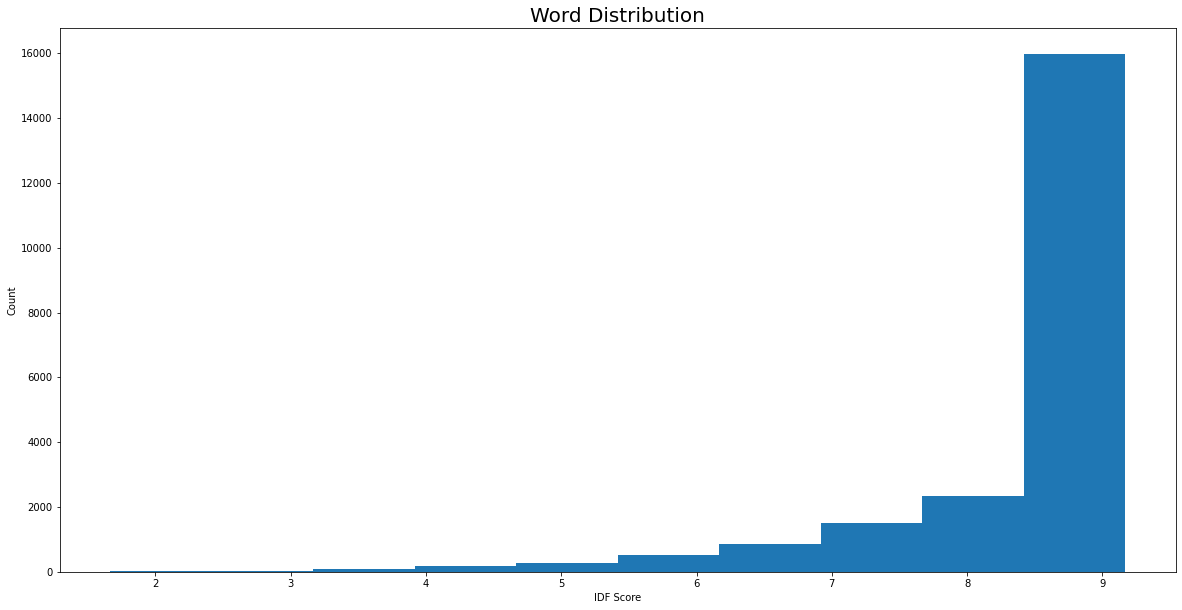

In [7]:
plt.figure(figsize = (20,10))
plt.hist(vectorizer._tfidf.idf_)
plt.xlabel("IDF Score")
plt.ylabel("Count")
plt.title("Word Distribution", fontsize = 20)
        

In [8]:
# Selecting top 10% most frequently occouring words
idf_vocab = idf_vocab[idf_vocab <= idf_vocab.quantile(q = 0.1)]
print(len(idf_vocab))
idf_vocab.head()

2206


abandon    6.815267
able       6.170910
abuse      6.527585
accept     6.458592
account    7.087201
dtype: float64

In [9]:
set(idf_vocab.index)

{'climb',
 'havin',
 'cigarette',
 'bedroom',
 'crew',
 'government',
 'ridin',
 'sentence',
 'fight',
 'bastard',
 'lead',
 'knockin',
 'heroes',
 'wreck',
 'room',
 'feed',
 'angels',
 'refrain',
 'spark',
 'defeat',
 'worlds',
 'ticket',
 'grey',
 'henny',
 'home',
 'orange',
 'haha',
 'constant',
 'darkest',
 'distance',
 'sure',
 'shield',
 'sippin',
 'speak',
 'darlin',
 'apartment',
 'bore',
 'gift',
 'halfway',
 'upside',
 'represent',
 'cameras',
 'stomach',
 'maintain',
 'clique',
 'rid',
 'relax',
 'warm',
 'finest',
 'refuse',
 'horizon',
 'string',
 'lovin',
 'deaf',
 'heel',
 'scenes',
 'freakin',
 'worry',
 'burden',
 'clutch',
 'chair',
 'thousand',
 'send',
 'figure',
 'fence',
 'girls',
 'downtown',
 'kinda',
 'sin',
 'average',
 'hit',
 'hiphop',
 'prepare',
 'chop',
 'everlasting',
 'half',
 'tragedy',
 'people',
 'grave',
 'dance',
 'hardest',
 'pullin',
 'rocket',
 'cheer',
 'whoa',
 'worship',
 'company',
 'trippin',
 'frown',
 'weather',
 'carpet',
 'direction',

In [10]:

vectorizer = CountVectorizer(decode_error='ignore'
                            # ,ngram_range = (1,2)
                            ,strip_accents = 'ascii'
                            # ,smooth_idf = False
                            ,vocabulary = set(idf_vocab.index)
                        )
X = vectorizer.fit_transform(pop_df)
print(X.shape)
# 7042 -> Training instances
# 21954 -> Total words
vocab= vectorizer.get_feature_names_out()
print(vocab)
print(X.toarray()[1])

(7042, 2206)
['abandon' 'able' 'abuse' ... 'youth' 'zero' 'zone']
[0 0 0 ... 0 0 0]


# GAN

In [11]:
from utils import Logger

import torch
from torch import nn, optim
from torch.autograd.variable import Variable
from torch.utils.data import DataLoader


In [12]:
X = torch.tensor(X.toarray())
print(X.shape, X.shape[0])
vocab_size = X.shape[1]

batch_size = 32
num_batches = X.shape[0]//batch_size

dataloader = DataLoader(X, batch_size= batch_size)

noise_input_dimension = 516

dataloader

torch.Size([7042, 2206]) 7042


# Discriminator Net

In [13]:
class DiscriminatorNet(torch.nn.Module):
    """
    A three hidden-layer discriminative neural network
    """
    def __init__(self):
        super(DiscriminatorNet, self).__init__()
        n_features = vocab_size
        n_out = 1
        
        self.hidden0 = nn.Sequential( 
            nn.Linear(n_features, 2000),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.hidden1 = nn.Sequential(
            nn.Linear(2000, 1500),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.hidden2 = nn.Sequential(
            nn.Linear(1500, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.hidden3 = nn.Sequential(
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.hidden4 = nn.Sequential(
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.out = nn.Sequential(
            torch.nn.Linear(256, n_out),
            torch.nn.Sigmoid()
        )

    def forward(self, x):
        x = x.type(torch.FloatTensor)
        x = self.hidden0(x)
        x = self.hidden1(x)
        x = self.hidden2(x)
        x = self.hidden3(x)
        x = self.hidden4(x)
        x = self.out(x)
        return x
    
def vec_to_text(array):
    return list(map(lambda vec: " ".join(list(vocab[vec > 0.5])), array))

def text_to_vec(array):
    return vectorizer.fit_transform(array)
    # return images.view(images.size(0), 784)

# def vectors_to_images(vectors):
#     return vectors.view(vectors.size(0), 1, 28, 28)

# Generator Network

In [14]:
class GeneratorNet(torch.nn.Module):
    """
    A three hidden-layer generative neural network
    """
    def __init__(self):
        super(GeneratorNet, self).__init__()
        n_features = noise_input_dimension
        n_out = vocab_size
        
        self.hidden0 = nn.Sequential(
            nn.Linear(n_features, 700),
            nn.LeakyReLU(0.2)
        )
        self.hidden1 = nn.Sequential(            
            nn.Linear(700, 900),
            nn.LeakyReLU(0.2)
        )
        self.hidden2 = nn.Sequential(
            nn.Linear(900, 1024),
            nn.LeakyReLU(0.2)
        )
        self.hidden3 = nn.Sequential(
            nn.Linear(1024, 1500),
            nn.LeakyReLU(0.2)
        )
        self.hidden4 = nn.Sequential(
            nn.Linear(1500, 2000),
            nn.LeakyReLU(0.2)
        )
        self.out = nn.Sequential(
            nn.Linear(2000, n_out),
            nn.Tanh()
        )

    def forward(self, x):
        x = x.type(torch.FloatTensor)
        x = self.hidden0(x)
        x = self.hidden1(x)
        x = self.hidden2(x)
        x = self.hidden3(x)
        x = self.hidden4(x)
        x = self.out(x)
        return x
    
# Noise
def noise(size):
    n = Variable(torch.randn(size, noise_input_dimension))
    # n = Variable(torch.randn(size, 256))
    if torch.cuda.is_available(): return n.cuda() 
    return n

In [15]:
discriminator = DiscriminatorNet()
generator = GeneratorNet()

if torch.cuda.is_available():
    discriminator.cuda()
    generator.cuda()

In [16]:
from torchsummary import summary

summary(discriminator,input_size=(X.shape))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1           [-1, 7042, 2000]       4,414,000
         LeakyReLU-2           [-1, 7042, 2000]               0
           Dropout-3           [-1, 7042, 2000]               0
            Linear-4           [-1, 7042, 1500]       3,001,500
         LeakyReLU-5           [-1, 7042, 1500]               0
           Dropout-6           [-1, 7042, 1500]               0
            Linear-7           [-1, 7042, 1024]       1,537,024
         LeakyReLU-8           [-1, 7042, 1024]               0
           Dropout-9           [-1, 7042, 1024]               0
           Linear-10            [-1, 7042, 512]         524,800
        LeakyReLU-11            [-1, 7042, 512]               0
          Dropout-12            [-1, 7042, 512]               0
           Linear-13            [-1, 7042, 256]         131,328
        LeakyReLU-14            [-1, 70

# Optimization

In [17]:
# Optimizers
d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002)
g_optimizer = optim.Adam(generator.parameters(), lr=0.0002)

# Loss function
loss = nn.BCELoss()

# Number of steps to apply to the discriminator
d_steps = 1  # In Goodfellow et. al 2014 this variable is assigned to 1
# Number of epochs
num_epochs = 200

# Training

## bleh

In [18]:
def real_data_target(size):
    '''
    Tensor containing ones, with shape = size
    '''
    data = Variable(torch.ones(size, 1))#.type(torch.LongTensor)
    if torch.cuda.is_available(): return data.cuda()
    return data

def fake_data_target(size):
    '''
    Tensor containing zeros, with shape = size
    '''
    data = Variable(torch.zeros(size, 1))#.type(torch.LongTensor)
    if torch.cuda.is_available(): return data.cuda()
    return data

In [19]:
def train_discriminator(optimizer, real_data, fake_data):
    # Reset gradients
    optimizer.zero_grad()
    
    # 1.1 Train on Real Data
    # print("Training Discriminator on real data")
    prediction_real = discriminator(real_data)
    # Calculate error and backpropagate
    # print("real_data:", real_data.size(), 
    #     "\nprediction_real:", prediction_real.size(),
    #     "\nreal_data_target:", real_data_target(real_data.size(0)).size())
        
    error_real = loss(prediction_real, real_data_target(real_data.size(0)))
    error_real.backward()

    # 1.2 Train on Fake Data
    prediction_fake = discriminator(fake_data)
    # Calculate error and backpropagate
    error_fake = loss(prediction_fake, fake_data_target(real_data.size(0)))
    error_fake.backward()
    
    # 1.3 Update weights with gradients
    optimizer.step()
    
    # Return error
    return error_real + error_fake, prediction_real, prediction_fake

def train_generator(optimizer, fake_data):
    # 2. Train Generator
    # Reset gradients
    optimizer.zero_grad()
    # Sample noise and generate fake data
    prediction = discriminator(fake_data)
    # Calculate error and backpropagate
    error = loss(prediction, real_data_target(prediction.size(0)))
    error.backward()
    # Update weights with gradients
    optimizer.step()
    # Return error
    return error

## Generate Samples for Testing

In [20]:
num_test_samples = 16
test_noise = noise(num_test_samples)
test_noise.shape

torch.Size([16, 516])

## Start Training

In [21]:
logging = Logger(model_name='VGAN_v2.0', data_name='tcc_ceds_music_dataset')

for epoch in range(num_epochs):
    # for n_batch, real_batch in tqdm(enumerate(dataloader)):
    for n_batch, real_batch in enumerate(dataloader):
        # print(n_batch, real_batch.size())

        # 1. Train Discriminator
        real_data = Variable(real_batch)
        if torch.cuda.is_available(): real_data = real_data.cuda()
        
        # Generate fake data and train G
        
        # print(real_data.size(), real_data.size(0), noise(real_data.size(0)).size())
        fake_data = generator(noise(real_data.size(0))).detach()
        # print("Fake Data:",fake_data.shape)
        
        # Train D
        d_error, d_pred_real, d_pred_fake = train_discriminator(d_optimizer,
                                                                real_data, fake_data)

        # 2. Train Generator
        # Generate fake data
        fake_data = generator(noise(real_batch.size(0)))
        # Train G
        g_error = train_generator(g_optimizer, fake_data)
        # Log error
        logging.log(d_error, g_error, epoch, n_batch, num_batches)

        # Display Progress
        if (n_batch) % 50 == 0:
            display.clear_output(True)
            # Display Images
            test_output = generator(test_noise).data.cpu().type(torch.FloatTensor)
            test_text = vec_to_text(test_output)
            # logging.log_images(test_text, num_test_samples, epoch, n_batch, num_batches)
            # Display status Logs
            logging.display_status(
                epoch, num_epochs, n_batch, num_batches,
                d_error, g_error, d_pred_real, d_pred_fake
            )
        #Model Checkpoints
        logging.save_models(generator, discriminator, epoch)

Epoch: [199/200], Batch Num: [200/220]
Discriminator Loss: 0.6542, Generator Loss: 1.9055
D(x): 0.8485, D(G(z)): 0.2999


# Check Output

In [22]:
vec_to_text(generator(test_noise).data.cpu().type(torch.FloatTensor))

['alright away baby bank better bitch black blood blue bout build burn cat cause chill christmas close clown come crazy darling days deal death deep dollars drown earth easy enemies eye fail fate feel fell fever fight figure flavor flower forever freak fuck game garden gaze get givin go gonna good gotta grind guess hear hearts hell hold home house keep knees know lead leave lie life like listen little live long lookin make march minute money morning mother motion music need nigga niggas night oooh party people pimp play promise real relax rely ride right river rockin runnin sail say searchin secret sentimental sheet shit sign silence sleep slow somethin soon sound spirit square start stay stayin stranger string strong sure surrender swag sweet take talk talkin tell thing throw time today tonight trap tree trip wait want water ways whisper wicked wind wonder work write wrong yeah young',
 'away baby bitch black blood blue bout build burn christmas close clown come crazy darling days dea

***
# END
***